In [1]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00


### Import Libraries

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import nltk
import pickle
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import re
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
porter = PorterStemmer()
import string

from textblob import TextBlob
from os import path
import nltk
nltk.download('punkt')
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Load Dataset

In [4]:
# Load the "wealth-alpaca_lora" dataset from Hugging Face
dataset = load_dataset("gbharti/wealth-alpaca_lora")

# Convert the dataset into a DataFrame
df = pd.DataFrame(dataset["train"])

df.head(5)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

,output,instruction,input
0,The car deal makes money 3 ways. If you pay in...,"For a car, what scams can be plotted with 0% f...",
1,"That is kind of the point, one of the hopes is...",Why does it matter if a Central Bank has a neg...,
2,"Pay off your debt. As you witnessed, no ""inve...",Where should I be investing my money?,
3,"Equity options, at least those traded in the A...",Specifically when do options expire?,
4,"Automatic exercisions can be extremely risky, ...",Negative Balance from Automatic Options Exerci...,


### Pre-Processing

#### 1. Check Null Values

In [5]:
df.isnull().sum()

output         0
instruction    0
input          0
dtype: int64

#### 2. Remove Punctuations

In [6]:
# remove punctations
df['o']=df['output'].str.replace('"', '')
df['o'] = df['o'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
df['o'] = df['o'].apply(lambda elem: re.sub(r"\d+", "", elem))

df['i']=df['instruction'].str.replace('"', '')
df['i'] = df['i'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
df['i'] = df['i'].apply(lambda elem: re.sub(r"\d+", "", elem))

#### 3. Clean, Remove Stop Words, Punctuations, lemmatize

In [7]:
def preprocess_txt(data):

  data = word_tokenize(data) # create tokens
  data = [x.lower() for x in data] # lowercase letters
  data = [re.sub('[0-9]+', '', x) for x in data] # remove numbers
  data = [porter.stem(word) for word in data] # stemming
  data = [w for w in data if not w in STOP_WORDS] # remove stop words
  data = list(filter(lambda token: token not in (str.maketrans('', '', string.punctuation)), data)) # remove punctutations
  data = [x for x in data if len(x) > 1] # len > 1
  data = [x for x in data if ' ' not in x] # no space

  return data

In [8]:
df['clean_output'] = df['o'].apply(preprocess_txt)
df['clean_instruct'] = df['i'].apply(preprocess_txt)

In [9]:
df.head(2)

,output,instruction,input,o,i,clean_output,clean_instruct
0,The car deal makes money 3 ways. If you pay in...,"For a car, what scams can be plotted with 0% f...",,The car deal makes money ways If you pay in o...,For a car what scams can be plotted with fina...,"[car, deal, money, way, pay, lump, payment, pa...","[car, scam, plot, financ, vs, rebat]"
1,"That is kind of the point, one of the hopes is...",Why does it matter if a Central Bank has a neg...,,That is kind of the point one of the hopes is ...,Why does it matter if a Central Bank has a neg...,"[kind, point, hope, incentiv, bank, stop, stor...","[whi, doe, matter, central, bank, ha, neg, int..."


### EDA

### 1. Sentiment polarity check with TextBlob

When a sentence is analyzed using TextBlob, it provides two distinct metrics: polarity and subjectivity. Polarity falls within the range of [-1, 1], with -1 indicating a negative sentiment and +1 indicating a positive sentiment. This metric serves as a valuable tool for assessing data distribution.

In [10]:
df['clean_str_o'] = [' '.join(map(str,l)) for l in df['clean_output']]
df['sentiment_o'] = df['clean_str_o'].apply(lambda x: TextBlob(x).sentiment.polarity)

df['clean_str_i'] = [' '.join(map(str,l)) for l in df['clean_instruct']]
df['sentiment_i'] = df['clean_str_i'].apply(lambda x: TextBlob(x).sentiment.polarity)

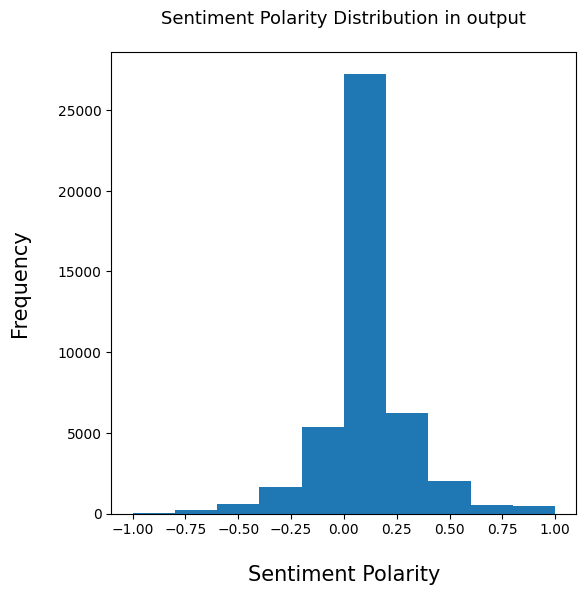

In [11]:
plt.figure(figsize=(6,6))
plt.margins(0.05)
plt.xlabel('Sentiment Polarity', fontsize =15, labelpad=20)
plt.ylabel('Frequency', fontsize =15, labelpad=20)
plt.hist(df['sentiment_o'], bins=10)
plt.title('Sentiment Polarity Distribution in output', fontsize =13, pad=20)
plt.show()

The above graph shows that most of our output column content revolves between 0 and 0.25 indicating most of them have positive words. A few words are negative as well but our dataset seems to be fair as it has a very minimal negative word distribution.

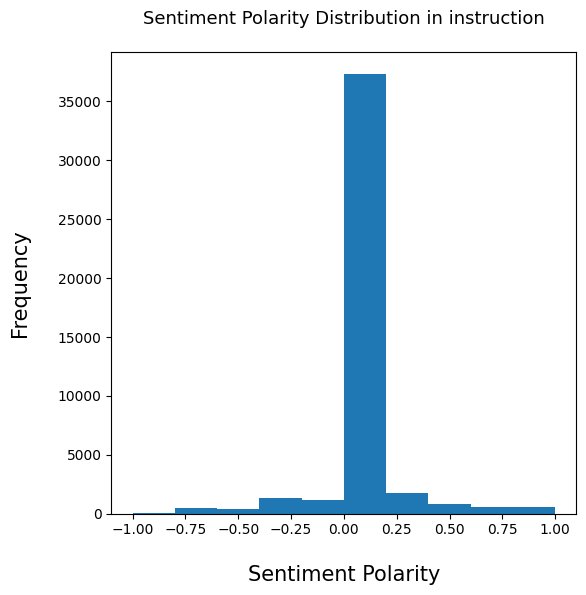

In [12]:
plt.figure(figsize=(6,6))
plt.margins(0.05)
plt.xlabel('Sentiment Polarity', fontsize =15, labelpad=20)
plt.ylabel('Frequency', fontsize =15, labelpad=20)
plt.hist(df['sentiment_i'], bins=10)
plt.title('Sentiment Polarity Distribution in instruction', fontsize =13, pad=20)
plt.show()

The instruction graph shows that most values at 0 which is neutral. Rest negative words are very minimal which can be ignored

#### 2. 100 Most common words

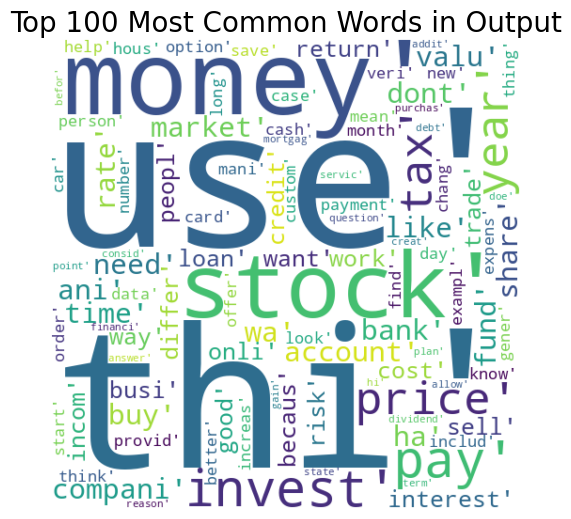

In [13]:
import itertools

word = df['clean_str_o']
words = []
my_word_arr = []
a = []
for wordlist in word:
    my_word_arr.append(wordlist.split(' '))

for arr in my_word_arr:
  ab = itertools.chain(arr)
  a += ab

mostcmn = FreqDist(a).most_common(100)
wordcloud = WordCloud(width=500, height=500, background_color='white').generate(str(mostcmn))
fig = plt.figure(figsize=(5,5), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in Output', fontsize=20)
plt.tight_layout(pad=0)
plt.show()

Looking the graph we can say that most common used words in output includes money, invest, use, stock etc

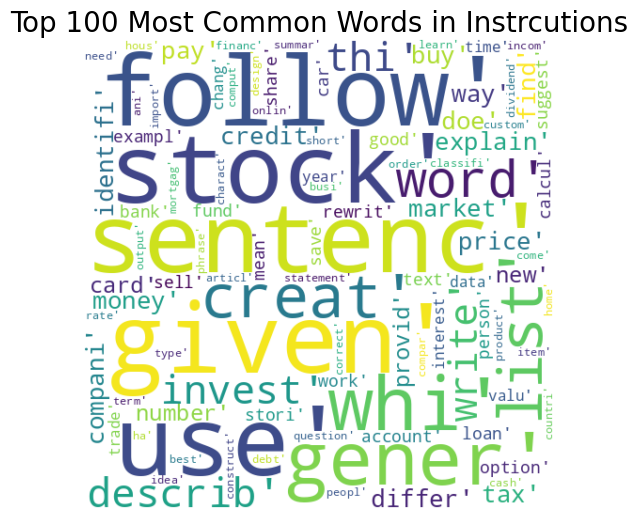

In [14]:
word = df['clean_str_i']
words = []
my_word_arr = []
a = []
for wordlist in word:
    my_word_arr.append(wordlist.split(' '))

for arr in my_word_arr:
  ab = itertools.chain(arr)
  a += ab

mostcmn = FreqDist(a).most_common(100)
wordcloud = WordCloud(width=500, height=500, background_color='white').generate(str(mostcmn))
fig = plt.figure(figsize=(5,5), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in Instrcutions', fontsize=20)
plt.tight_layout(pad=0)
plt.show()

Similarly, in instruction feature we can see most common words are use, follow, sentence, money etc

#### 3. Applying Word2Vec to see most similar words learning from Model

In [15]:
model = Word2Vec(df['clean_output'], window=5, min_count=5, sg=1)

In [16]:
df1 = pd.DataFrame(model.wv.most_similar('invest'), columns=['Similar Words', 'Similarity'])

In [24]:
df1

,Similar Words,Similarity
0,lowrisk,0.727413
1,highyield,0.715781
2,riskier,0.711066
3,stocksbond,0.703925
4,handsoff,0.701258
5,dividendpay,0.695056
6,stockmarket,0.694862
7,lowyield,0.689190
8,lowerrisk,0.688948
9,taxeffici,0.686913


This word2Vec graph is showing us the similar words that model identified similar to invest are stocksbond, low risk, diversification etc

In [25]:
df2 = pd.DataFrame(model.wv.most_similar('money'), columns=['Similar Words', 'Similarity'])

In [26]:
df2

,Similar Words,Similarity
0,stash,0.699309
1,divert,0.696719
2,interestbear,0.692359
3,cash,0.663261
4,moni,0.657477
5,savingsinvest,0.651400
6,nontaxadvantag,0.651327
7,reluct,0.642709
8,moneymarket,0.642320
9,penaltyfre,0.642226


This word2Vec table is showing us the similar words that model identified similar to money are stash, cash, diversification, moneymarket etc

Since the model, I am gonna build is a chatbot, it's very important to look at the data and understand if it has any biased content so that our model won't learn wrong. Looking at the analysis it is evident that the data is unbiased and good to move forward. The model mainly focuses on only 2 variables. In our case it is instruction and output and both look good.

The second main analysis that I carried out was to see if the data is relevant to the finance sector and through the 100 most commonly used words I can say that Yes the data mostly revolves around the finance sector.

The last analysis was to dig deeper and understand the cluster of the words the model has learned from the dataset passed. When I checked the word-vec similarity with Invest and Money words it looked good that the model is learning the cluster embeddings correctly. Proving that our dataset is good to move ahead for the analysis!